# Intuitive PCApproximation

This is an exploration into Principal Component Analysis (PCA) with the aim to explain to myself (and potentially others) in an intuitive way how PCA works.

I managed to create an algorithm that, while not as efficient as typical implementations of PCA (e.g. [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)), still runs reasonably quickly and, most importantly, is rather easy to understand – at least so I think.


**What is PCA?**  
PCA is a form of dimensionality reduction very commonly used in Data Science and Machine Learning. Most datasets contain a very large amount of variables, which makes it difficult to identify trends. PCA helps with this, as it reduces the number of variables while retaining as much variance (information) as possible. Visually, PCA works by plotting the points and then finding n orthogonal lines that maximise the variance, as seen in the image below. The spread of the points along these lines represent the n new variables.  

_Example:_  
To reduce a dataset from two variables to one, we first plot the points on a 2D plane and then find a single line that maximises their variance.  
![](assets/pca-illustration.jpg)  
_(Taken from https://dinhanhthi.com/principal-component-analysis/)_


**My approximation**  
Since the axes in euclidean geometry are already, by definition, orthogonal to one another, we can simply rotate them to maximise the variance along them. In 3D, we would first rotate the X-axis in any direction to maximise variance along it and then rotate the Y-axis while keeping the X-axis fixed and the Y-axis perpendicular to it. Once the variance has been maximised along both axes, the new variables are the X and Y-axes. This can be scaled up to any number of input and output variables.

Since rotating the axes is not really feasible, my algorithm rotates the points instead, but the idea remains the same.

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

import plotly.express as px

from sklearn import decomponsition
from sklearn import preprocessing

import statistics as stats

import mgen  # Generating rotation matrices

In [2]:
np.set_printoptions(suppress=True)  # Don't use scientific notation when printing numpy arrays

# Data creation

In [3]:
# Function to normalize data
normalize = lambda arr: preprocessing.normalize([arr])[0]

In [4]:
def gen3dData(m, c, size=20, noiseFactor=0.3):
    return genNdData(n=3, size=size, noiseFactor=noiseFactor)
    # y=mx+c
    xs = np.random.uniform(size=size)
    ys = [m * x**2 + c + np.random.normal() * noiseFactor for x in xs]
    zs = [m * x**2 + c + np.random.normal() * noiseFactor for x in xs]
    return xs, ys, zs

# Generates n-dimensional data (n input variables)
def genNdData(n=3, size=20, noiseFactor=0.3):
    variables = np.zeros((n, size))
    variables[0] = xs = np.random.uniform(size=size)

    for dim in range(1, n):
        variables[dim] = [x**(dim+1) + np.random.normal() * noiseFactor for x in xs]

    variables = [normalize(xs) for xs in variables]

    return variables

In [5]:
def unzip(xs):
    return list( zip(*xs) )

# Same as transposing a matrix
transpose = lambda xs: unzip(xs)

('Variance: ', 0.008650515309871048)

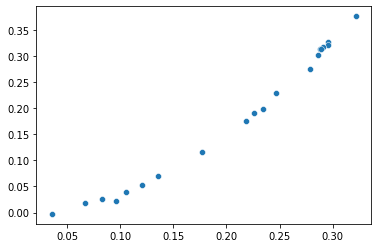

In [6]:
xs, ys = genNdData(n=2, size=20, noiseFactor=0.01)
vectors2d = transpose([xs, ys])

sns.scatterplot(x=xs, y=ys)

"Variance: ", stats.variance(xs)

# PCA (sklearn)

In [7]:
# PCA
pca = decomposition.PCA(n_components=1)
X_reduced = pca.fit_transform(vectors2d)
pca.explained_variance_ratio_
pca.components_

array([[-0.57955567, -0.81493265]])

<AxesSubplot:>

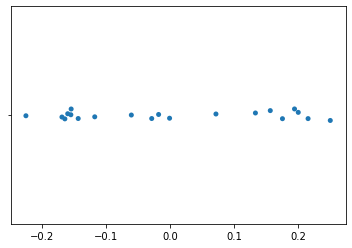

In [8]:
# Plot PCA
xs_reduced = np.transpose(X_reduced)[0]
sns.stripplot(x=xs_reduced, jitter=0.03)

# My approximation

**Rotations**  
In 3D we can generally say that we rotate around an axis or vector. This, however, is particular about the three dimensions that we live in and cannot be transferred to other dimensions: In 2D we can't rotate around an axis and neither can we in higher dimensions.

When we say that we rotate _around_ an axis, what we are really saying is that we are keeping the points constant (invariant) along the axis. The element (pivot) that we are keeping invariant depends on the dimension we are rotating in: In 2D we are only keeping the pivot **point** constant; In 3D it is a pivot **line**; In 4D it would be a pivot **rectangle**, etc.

| Dimensions ||||||| Invariant Pivot |
| ------------- | ------------------ |
| 2D         ||||||| 0D Point |
| 3D         ||||||| 1D Line |
| 4D         ||||||| 2D Rectangle |
| 5D         ||||||| 3D Cuboid |
| 6D         ||||||| 4D Tessaract |
| ...        ||||||| ... |
  
No matter how many dimensions we are operating in, we are always rotating on a 2D plane. Such a plane is typically described by two orthogonal vectors.

**Example:**  
In the following code block the vector \[1 0 0] is rotated 90° around the Z-axis, which corresponds to a rotation by 90° on the plane spanning the X and Y-axes (XY-plane).

In [9]:
vectorToRotate = [1, 0, 0]

rotation_degrees = 90
rotation_radians = np.radians(rotation_degrees)

plane_v1 = np.array([1, 0, 0])
plane_v2 = np.array([0, 1, 0])

# Create two rotation matrices to compare
M1 = mgen.rotation_around_axis([0, 0, 1], rotation_radians)
M2 = mgen.rotation_from_angle_and_plane(rotation_radians, plane_v1, plane_v2)

# e-16 is a floating point error and can be considered 0
print(M1.dot(vectorToRotate))
print(M2.dot(vectorToRotate))

[0. 1. 0.]
[0. 1. 0.]


## PCA approximation in 2D

To find the optimal rotation we rotate the points in small steps. On each step, we rotate by 1° clockwise and by 1° anti-clockwise and choose the direction that increases the variance along the X-axis. If the variance cannot be increased, we're done.

In [10]:
# Rotate a single vector in 2D
# (In 2D there is only one plane to rotate on)
def rotate(vec, angle_deg):
    angle_rad = np.radians(angle_deg)
    M = mgen.rotation_from_angle(angle_rad)
    return M.dot(vec)

# Rotate a list of vectors in 2D
def rotateAll(vectors, angle_deg):
    angle_rad = np.radians(angle_deg)
    M = mgen.rotation_from_angle(angle_rad)
    return [M.dot(v) for v in vectors]

In [11]:
def xsOf(vectors):
    return list( list(unzip(vectors))[0] )

def ysOf(vectors):
    return list( list(unzip(vectors))[1] )

In [12]:
def plot1d(xs):
    sns.stripplot(x=xs, jitter=0.03)

def plot2d(vectors):
    xs, ys = unzip(vectors)
    return sns.scatterplot(xs, ys)

In [13]:
angle = 0
angle_change = 1

var = -1
var_new = 0

vectors = np.copy(vectors2d)

while var < var_new:
    var = var_new

    vectors_left = rotateAll(vectors, -angle_change)
    vectors_right = rotateAll(vectors, angle_change)

    var_left = stats.variance(xsOf(vectors_left))
    var_right = stats.variance(xsOf(vectors_right))

    if var_left < var_right:
        var_new = var_right
        angle += angle_change
        vectors = vectors_right

    elif var_right < var_left:
        var_new = var_left
        angle -= angle_change
        vectors = vectors_left

    else:
        break

print(f'Optimal rotation: {angle}° clockwise')
print(f'Variance along X-axis (1st PC): {var_new}')

Optimal rotation: -54° clockwise
Variance along X-axis (1st PC): 0.02544352613903337


#### Results
And now let's look at how the approximation compares to standard PCA implementations:

In [14]:
# Variance explained
xs, ys = unzip(vectors2d)
var_explained = var_new/(stats.variance(xs) + stats.variance(ys))

print( "Variance explained by approximation:", var_explained)
print( "Variance explained by PCA:", pca.explained_variance_ratio_)

print("Error: ", (var_explained - pca.explained_variance_ratio_)/ pca.explained_variance_ratio_)

Variance explained by approximation: 0.9938083377771011
Variance explained by PCA: [0.99390981]
Error:  [-0.00010209]


Comparing the variance explained by the 1st Principal Component found by standard PCA and by the approximation, the error is roughly 0.0001% depending on the data. Not bad!

To extract the 1st Principal Component we can simply take the x-values (2nd PC is y-values) of the resulting vectors:

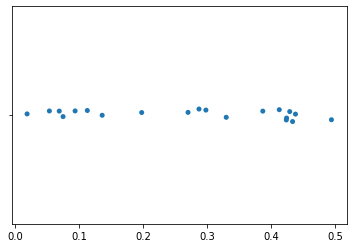

In [15]:
plot1d(xsOf(vectors))

## PCA approximation in 3D and higher

### Generating and visualising some sample data

In [16]:
def plot3d(vectors):
    xs, ys, zs = unzip(vectors)
    fig = px.scatter_3d(x=xs, y=ys, z=zs)
    fig.show()

In [17]:
# Generate data
xs, ys, zs = genNdData(n=3, noiseFactor=0.02)
vectors3d = transpose([xs, ys, zs])

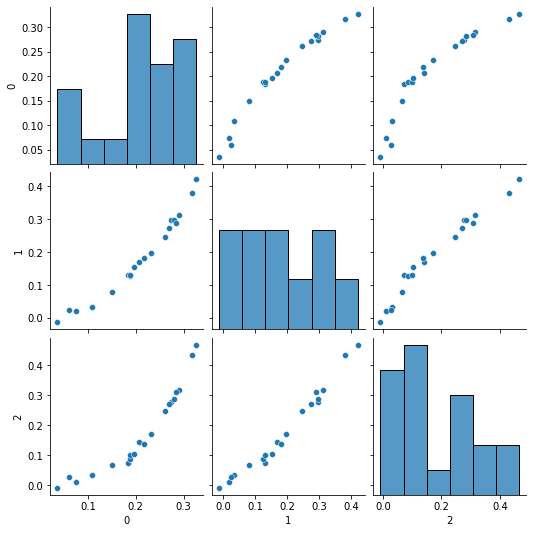

In [18]:
df = pd.DataFrame(vectors3d)
sns.pairplot(df)

In [19]:
plot3d(vectors3d)

### Algorithm in 3D and higher dimensions

The approach here is mostly the same as in 2D:
- We first rotate the points in small steps. On each step we rotate clockwise and anti-clockwise, choosing the direction that increases variance along the X-axis until we reach a maxima. We do this on every plane where the target axis is not invariant. For the X-axis in 3D this would be the XY and XZ planes.
- Once we reached maxima along the X-axis for rotations on all relevant planes, we focus on the Y-axis and maximise the variance along it. In order to not undo our work on the X-axis, we ignore all rotations that would affect it (all planes that include the X-axis). Hence in 3D we can only rotate on the YZ plane, but not the YX plane.
- This is progressively done for every axis until the number of axes we have maximised equals the number of PCs wanted, or until there is only one axis remaining, as there are no planes left that the points may be rotated on to maximise the last axis. (n-1 degrees of freedom)

Once complete, the X-axis is the 1st PC, the Y-axis the 2nd, etc.

#### Helper functions to rotate vectors

In [20]:
# Convert two axes into orthogonal vectors that describe their plane
def planeToVectors(dimension, axis1, axis2):
    v1 = np.zeros(dimension)
    v2 = np.zeros(dimension)
    v1[axis1] = 1
    v2[axis2] = 1
    return v1, v2

# e.g. In 3D between X and Z axes
#  planeToVectors(3, 0, 2)
#  -> [1 0 0], [0 0 1]

In [21]:
# Perform a clock-wise rotation by [rotation_deg]° on a list of vectors on the given plane
def rotateOnPlane(plane_v1, plane_v2, rotation_deg, vectors):
    # Create rotation matrix
    rotation_rad = np.radians(rotation_deg)
    M = mgen.rotation_from_angle_and_plane(rotation_rad, plane_v1, plane_v2)

    # Rotate all vectors
    return [M.dot(v) for v in vectors]

In [22]:
# Tries rotating vectors in both directions on the plane described by the two axes.
# Chooses the direction that maximises the variance along the optimisation_axis.
# 
# Returns (rotation_deg or -rotation_deg), new_variance, rotated_vectors

def bestRotationOnAxes(optimisation_axis, dimension, axis1, axis2, rotation_deg, vectors):
    # Generate orthogonal vectors describing the plane
    plane_v1, plane_v2 = planeToVectors(dimension, axis1, axis2)
    
    # Try rotating left (anti-clockwise)
    vectors_left = rotateOnPlane(plane_v1, plane_v2, -rotation_deg, vectors)
    points = unzip(vectors_left)[optimisation_axis]
    variance_left = stats.variance(points)

    # Try rotating right (clockwise)
    vectors_right = rotateOnPlane(plane_v1, plane_v2, rotation_deg, vectors)
    points = unzip(vectors_right)[optimisation_axis]
    variance_right = stats.variance(points)

    # Choose rotation the maximises the variance
    if variance_left > variance_right:
        return -rotation_deg, variance_left, vectors_left
    else:
        return rotation_deg, variance_right, vectors_right

In [23]:
# Rotates the points by [rotation_deg]° on every plane allowed to improve the variance along the optimisation_axis
# 
# To improve the X-axis alignment, the points are allowed to rotate on every plane,
# but to improve the Y-axis, the rotations may not affect the X-axis alignment
# In 3D: For X-axis alignment rotation on XY and XZ plane (YZ is also allowed, but will not affect X-axis)
#        For Y-axis alignment rotation on YZ, but not YX plane

def improveAxisAlignmentBy(optimisation_axis, dimensions, rotation_deg, vectors):
    if optimisation_axis == dimensions-1:
        points = unzip(vectors)[optimisation_axis]
        return stats.variance(points), vectors
        # TODO

    # Axes to pair with optimisation_axis to form the plane to rotate on.
    # Assumes all axes < optimisation_axis to be fixed and immutable
    for axis2 in range(optimisation_axis+1, dimensions):
        angle_diff, var, vectors = bestRotationOnAxes(
            optimisation_axis = optimisation_axis,
            dimension = dimensions,
            axis1 = optimisation_axis,
            axis2 = axis2,
            rotation_deg = rotation_deg,
            vectors = vectors
        )

    return var, vectors

In [24]:
# Improve alignment along the optimisation_axis by rotating on the given plane (axis1, axis2)
# until a maxima in the variance is reached.
def optimiseAxisOnPlane(optimisation_axis, dimensions, axis1, axis2, rotation_deg, vectors):
    var_old = -1
    var = 0

    while var > var_old:
        var_old = var
        angle_diff, var, vectors = bestRotationOnAxes(
                optimisation_axis = optimisation_axis,
                dimension = dimensions,
                axis1 = axis1,
                axis2 = axis2,
                rotation_deg = rotation_deg,
                vectors = vectors
            )

    return var, vectors

The following helper function `approximatePC` approximates the optimal rotation to maximise the variance along the given axis. However, instead of starting at 0° and incrementally rotating by 1° until the optimum is reached, we can try an approach similar to binary search, where we "search" for the best rotation by initially making big jumps and then refining our search space: We start by rotating 90°, then 45°, then 22.5°, etc. until we have reached the desired precision (e.g. ≤1°). To reach a precision of 1° this method would take up to 8 steps instead of up to 90 when incrementing by 1°. If the initial efficiency of simply incrementing was $\Theta(n)$, the new algorithm runs in $\Theta(\lg n)$.

Since the relationship between rotation and variance is not always linear, I found that a factor of 1.5 produces better results than the factor of 2 mentioned above. Hence, we would be rotating by 90°, then 60°, 40°, 26.7°, etc. Finding the best angle would now take 13 steps instead of 8, but we still have an efficiency of $\Theta(\log_{1.5} n) = \Theta(\lg n)$ with a more accurate outcome. By decreasing the factor we can make it still more accurate but it would need longer to run.

In [25]:
# Find the nth principal component (target_pc) by optimising variance along its corresponding axis
# by rotating on all available planes.
# Makes sure to not affect previous principal components.
#
# It is highly recommended to execute it in order of increasing PC number

def approximatePC(from_dimension, target_pc, precision, vectors, log_factor=1.5):
    # Requires that prior PCs are already approximated in the input vectors

    var_old = -1
    var = 0

    # Instead of improving by a little bit every time, initially make big adjustments and get finer and finer
    # Approach is inspired by binary search.
    angle = 90  # Start at 90° changes instead of 180°, since flipping by 180° results in the same variance
    while angle > precision:
        var_old = var
        var, vectors = improveAxisAlignmentBy(target_pc, from_dimension, angle, vectors)

        angle = angle / log_factor


    return var, vectors

In [26]:
# Simulates PCA for
#  any number of input dimensions >= 2
#  and any number of desired Principal Components <= no. of dimensions
def myPCA(input_vectors, components, log_factor=1.5):
    precision = .1  # Smallest rotation-angle size (in degrees)

    dimensions = len(input_vectors[0])
    target_dimensions = components  # No. of Principal Components to find

    if target_dimensions > dimensions:
        raise Exception(f'Requested more components ({components}) than input data has dimensions ({dimensions})')

    variances = np.zeros(target_dimensions)

    vectors_new = np.copy(input_vectors)

    # Compute Principal Components
    for pc in range(target_dimensions):
            variances[pc], vectors_new = approximatePC(dimensions, pc, precision, vectors_new, log_factor)

    # Calculate variances explained by components
    total_var = 0
    for points in unzip(input_vectors):
        total_var += stats.variance(points)
    varsExplained = [var / total_var for var in variances]

    return {
        "variance explained": varsExplained,
        "components": unzip(vectors_new)[:target_dimensions]
    }

#### Demsonstration of approximation algorithm `myPCA`

In [27]:
vectors3d = transpose(genNdData(n=3, size=100))
results = myPCA(vectors3d, 3)
results['variance explained']

[0.8108474450655777, 0.1233672858781378, 0.06578526905628443]

In [28]:
vectors5d = transpose(genNdData(n=5, size=100))
results = myPCA(vectors5d, 3)
results['variance explained']

[0.5593309564391039, 0.1588819208072347, 0.12838213614982016]

In [29]:
vectors10d = transpose(genNdData(n=10, size=100))
results = myPCA(vectors10d, 3)
results['variance explained']

[0.428243962604282, 0.10745071173485049, 0.10147638091951613]

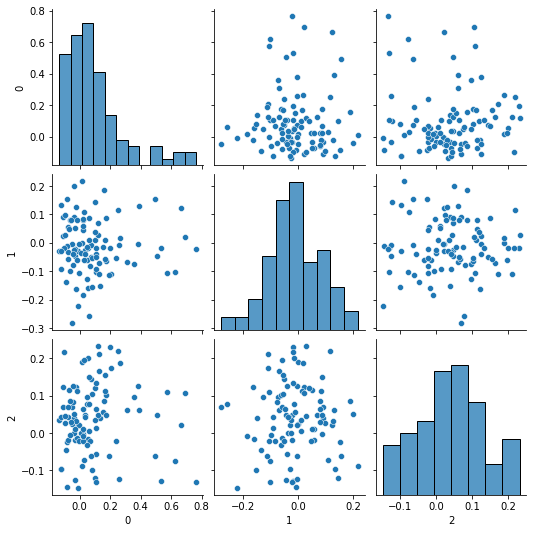

In [30]:
df = pd.DataFrame(transpose(results['components']))
sns.pairplot(df)
plot3d(transpose(results['components']))

#### Comparison with standard PCA

In [31]:
# PCA
X = np.ndarray.transpose(np.array(unzip(vectors10d)))

pca = decomposition.PCA(n_components=3)
X_reduced = pca.fit_transform(X)
print("Standard PCA explained variances:", pca.explained_variance_ratio_)

myPCAErrors = np.absolute(results['variance explained'] - pca.explained_variance_ratio_) / pca.explained_variance_ratio_
print("myPCA errors per component:", myPCAErrors)

Standard PCA explained variances: [0.42824768 0.10745068 0.10149645]
myPCA errors per component: [0.00000868 0.00000033 0.00019773]


# Conclusion

While it was clear from the beginning that I wasn't going to discover a revolutionary new approach to computing PCAs that is much faster than the tried and tested approach that many have worked on over the years, this approach is arguably much more intuitive to understand and is a very reasonable approximation of the standard approach (typical errors of < 0.0001% for each component).

I have learnt a good amount about both, PCA as well as rotations in n-dimensional space while researching for this project and hope that you, whoever may end up reading this, have too.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3c882279-82a6-4796-9acf-70d58cb2aa76' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>